# Ultimate Technologies Interview Challenge

### Part 1

**Instructions:** The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import logins data into a df and look at the format
logins_df = pd.read_json('./ultimate_challenge/logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Use info() to see the dtype of the column and if there are any null values.
logins_df.info()

# It looks as if there are no null values and the column is in datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
# I'll use .resample() to aggregate the logins into 15 min intervals.

# First, I'll set the login_time column to be the index
logins_df.set_index('login_time', inplace=True)

In [5]:
# Resample at 15 minute time intervals and count the logins during that time period using .size()
login_counts = logins_df.resample('15T').size()
login_counts_df = pd.DataFrame(login_counts, columns = ['login_count'])
login_counts_df

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


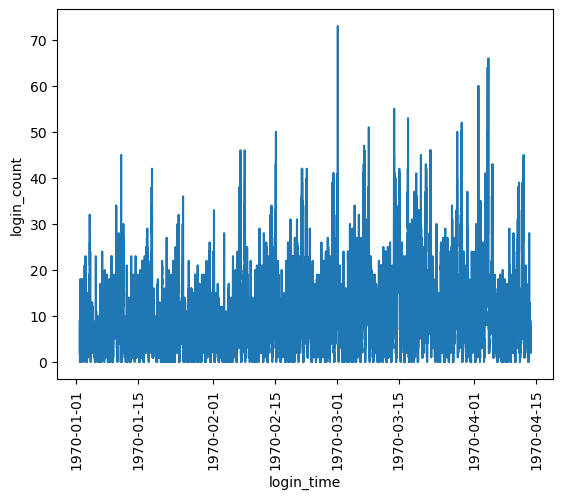

In [6]:
# Let's make a plot to visualize the login counts
sns.lineplot(data= login_counts_df, x = login_counts_df.index, y = 'login_count')
plt.xticks(rotation = 90)
plt.show()

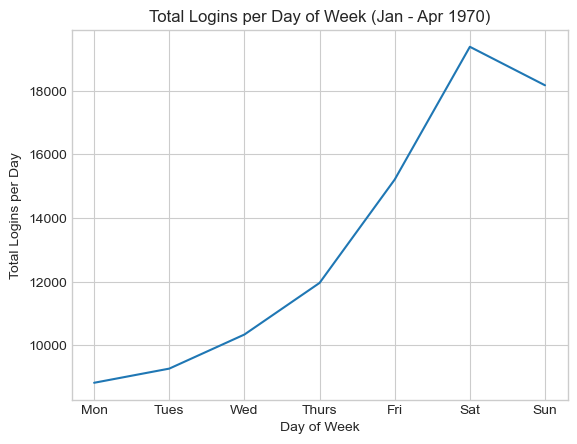

In [7]:
# The above visualization doesn't tell us much.  I'll group by day of week and see if there are any insights that can be gained.
plt.style.use('seaborn-v0_8-whitegrid')
login_counts_df['dayofweek'] = login_counts_df.index.dayofweek
login_counts_df.pivot_table(values = 'login_count', index = 'dayofweek', aggfunc = 'sum').plot()
plt.legend().remove()
plt.gca().set(xticks = range(7), xticklabels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Total Logins per Day')
plt.xlabel('Day of Week')
plt.title('Total Logins per Day of Week (Jan - Apr 1970)')
plt.show()

>There is a clear pattern to this.  Most logins occur during the weekend.  There is an uptick starting Thursday and the logins stay elevated through Friday, Saturday, and Sunday.  Monday, Tuesday, and Wednesday are clearly days with lower activity.

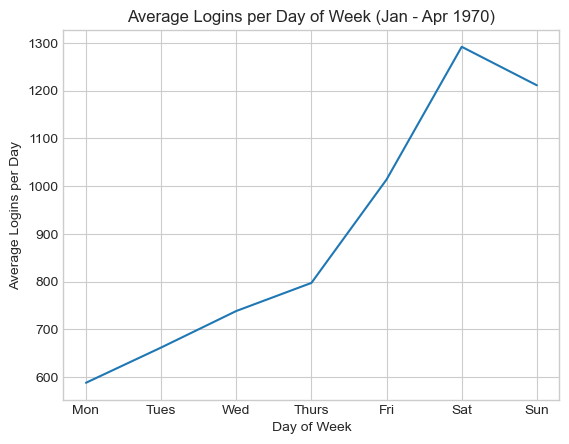

In [8]:
# The above visualization is great, but I'd also like to look at the average logins per day.
# To get the average logins per day of week, I'll aggregate the logins by date, recalculate the dayofweek and then create a pivot table using mean as the aggfunc

login_counts_df['login_date'] = login_counts_df.index.date
login_by_date_df = login_counts_df.groupby('login_date').sum()
login_by_date_df['dayofweek'] = pd.to_datetime(login_by_date_df.index).dayofweek

login_by_date_df.pivot_table(values = 'login_count', index = 'dayofweek', aggfunc = 'mean').plot()
plt.legend().remove()
plt.gca().set(xticks = range(7), xticklabels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Average Logins per Day')
plt.xlabel('Day of Week')
plt.title('Average Logins per Day of Week (Jan - Apr 1970)')
plt.show()

>As expected, this follows a similar pattern to the total logins visualization above, but having the average logins per day of the week is more useful to know than the total over the time period, as this will allow more easy comparison to future data (e.g., we'll know quickly if the logins for that day are above or below average).

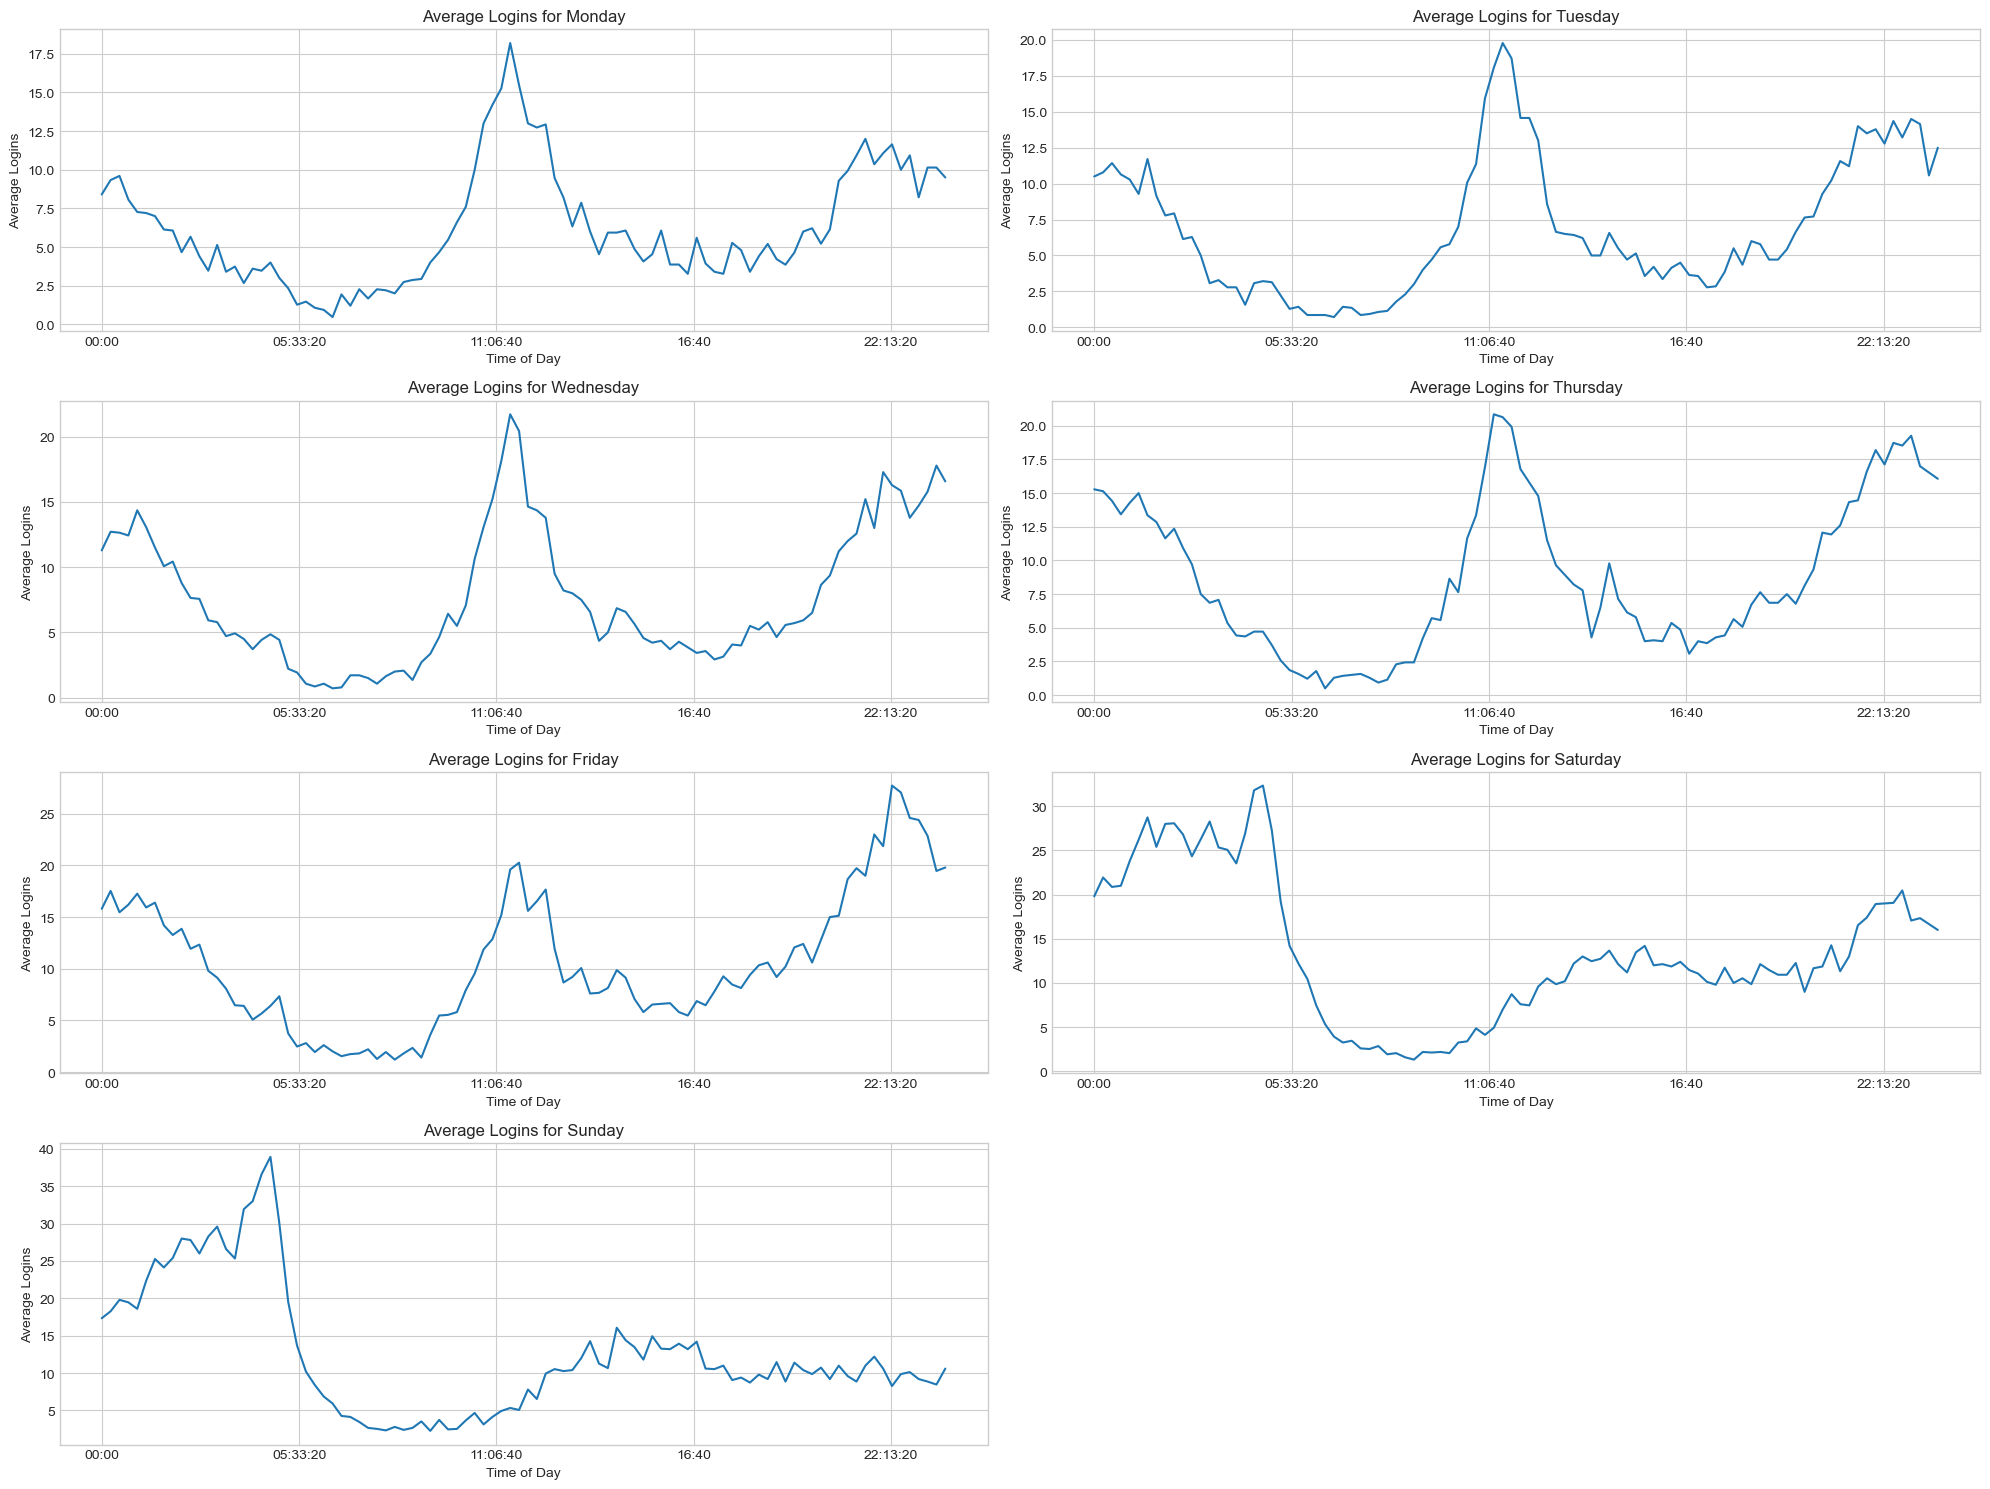

In [9]:
# Let's look at each day's data to see if there is a pattern within each day for logins
day_mapping = {0:'Monday', 1:'Tuesday', 2: 'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}

fig, ax = plt.subplots(nrows = 4, ncols= 2, figsize = (20,15))
ax = ax.flatten()

for day in np.sort(login_counts_df['dayofweek'].unique()):
    logins_by_day_df = login_counts_df[login_counts_df['dayofweek'] == day]
    logins_by_day_df.pivot_table(values = 'login_count', index = logins_by_day_df.index.time, aggfunc = 'mean').plot(ax = ax[day])
    ax[day].set_title(f'Average Logins for {day_mapping[day]}')
    ax[day].set_ylabel('Average Logins')
    ax[day].set_xlabel('Time of Day')
    ax[day].legend().remove()

ax[7].axis('off')
plt.tight_layout()
plt.show()

>This yields very interesting results.  Weekdays clearly have a spike in logins during the lunch hour and at night.  On Friday night/ Saturday morning, there is a spike in logins as well as Saturday night/ Sunday morning.  Weekday activity is concentrated at noon and midnight, weekend activity is conventrated overnight.

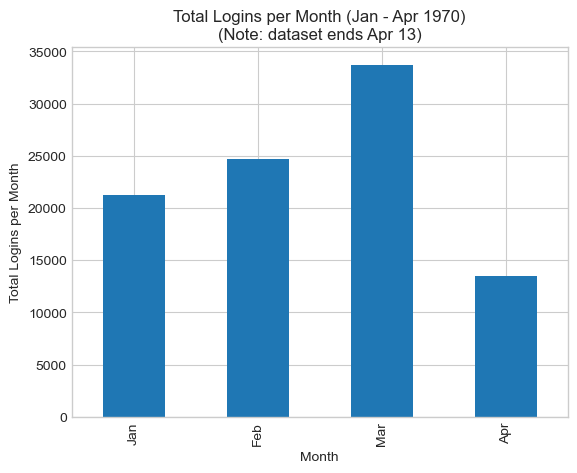

In [10]:
# Finally let's look to see if there are longterm trends in the data. We'll aggregate by month and see what the overall trend is.

login_counts_df.pivot_table(values = 'login_count', index = login_counts_df.index.month, aggfunc = 'sum').plot(kind = 'bar')
plt.legend().remove()
plt.gca().set(xticks = range(4), xticklabels = ['Jan', 'Feb', 'Mar', 'Apr'])
plt.ylabel('Total Logins per Month')
plt.xlabel('Month')
plt.title('Total Logins per Month (Jan - Apr 1970)\n(Note: dataset ends Apr 13)')
plt.show()

>It seems as if login activity is growing month over month which is a good sign.  Keep in mind, the dataset ends April 13, so Apr contains less than half of the months' data.

### Part 2

**Instructions:** The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.

>1. A key measure of success in this experiment would be a rise in cross-town traffic - we could track the number of drivers that start trips in one city and end trips in the other.  This metric would be a direct measure of the behavior the Ultimate managers are looking to encourage - a rise in cross-town trips would show that drivers are willing to accept trips / riders are more willing to take trips to the other town. Some secondary metrics that could be considered are the total number of drivers available in each city and average trip length/duration.  If there is a substantial change of drivers available in each city after the implementation of the toll-reimbursement or they significantly adjust their trip length/duration, that could show that more drivers are willing to serve both cities.
>   
>2. To compare the effectiveness of the proposed change I would design the following experiment.
>* First, I would make sure I have enough data on driver behavior and trip characteristics prior to the implementation of the toll-reimbursement program.  I would want to have a years worth of data that contains driver info and the trip info including start location, end location, time of the trip, and any toll costs. Having at least a years worth of data would allow us to analyze for seasonality shifts over the course of the year. Then, after the toll-reimbursement program is introduced, we can gather data for the next month.  Using this new data we can analyze for an increase in cross-town trips.  We would need to ensure our data collection methods would be consistent across these two time periods.
>* We would implement a two-sample t-test to analyze whether the mean of the cross-town trips changed significantly during the two sampling periods. Our null hypothesis would be that there is no change in the number of cross-town trips.  Using the new data we gathered and the historic data we could analyze whether the change in cross-town trips is statistically significant - in other words, is the change in cross-town trips outside the realm of liklihood given our historic data. The first set of data would include trips prior to the toll-reimbursement and the second set of data would include trips post toll-reimbursement.  I would sum up the number of cross-town trips for each, compute the average number of cross-town trips, and compare them against each other.
>* Then I would generate a p-value to express how likely it is that we received the number of cross-town trips in the second set of data, given what we observed in the first set of data.  If the p-value is less than 0.05, that would mean that the probability of obtaining the number of cross-town trips in our second set of data if our null hypothesis (that there is no effect of toll-reimbursement on cross-town trips) is true is less than 5%.  If the p-value is less than 0.05, I would tell the city operations team that the program appears to be a success, however we should continue to monitor the results to be sure that the results are consistent throughout the year (to make sure we account for any seasonality shifts). 

### Part 3

**Instructions:** Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [11]:
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Cleaning

In [12]:
# Let's import the data and perform some EDA:
rider_df = pd.read_json('./ultimate_challenge/ultimate_data_challenge.json')
rider_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


>Looking at the df, we need to put the date columns into datetime format, other than that, the dtypes look ok.  There are some null values and they relate to ratings, so it means they don't have any ratings input into the system for that particular user. Let's explore and see if it makes sense to convert these null values to 0.
>
>For our model, we'll have to create the target variable - I'll create a new column indicating whether the user was retained or not.

In [14]:
# Let's convert the date columns to datetime formats
rider_df['signup_date'] = pd.to_datetime(rider_df['signup_date'])
rider_df['last_trip_date'] = pd.to_datetime(rider_df['last_trip_date'])
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [15]:
# Let's explore and deal with the null values
np.sort(rider_df['avg_rating_of_driver'].unique())
np.sort(rider_df['avg_rating_by_driver'].unique())
rider_df['phone'].unique()

# There are no 0 values for either of the ratings columns.  We will change null values to 0.  Additionally we will change the null values in the phone column to a string of 'No Phone'
rider_df['avg_rating_of_driver'].fillna(0, inplace = True)
rider_df['avg_rating_by_driver'].fillna(0, inplace = True)
rider_df['phone'].fillna('No Phone', inplace = True)
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [16]:
# Let's convert the categorical variables into dummy variables
rider_df = pd.get_dummies(rider_df, columns = ['city', 'phone'])
rider_df

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_No Phone,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,False,True,False,False,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,True,False,False,True,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,True,False,False,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,False,True,False,False,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.0,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,False,True,False,False,False,True
49996,1,2014-01-24,0.0,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,True,False,False,False,False,True
49997,0,2014-01-31,5.0,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,False,False,True,True,False,False
49998,2,2014-01-14,3.0,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,True,False,False,False,False,True


In [17]:
# Let's create the target variable
most_recent_trip = np.max(rider_df['last_trip_date'].values) # The most recent last trip date was 2014-07-01

# Retention is defined as a user taking a trip within the preceeding 30 days. 
# Since the most recent trip was 07-01, I'll define retention as in the user taking a trip within the 30 days prior to July 1.
retention_threshold = most_recent_trip - pd.Timedelta(30,'days')
rider_df['retained'] = rider_df['last_trip_date'] > retention_threshold
rider_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_No Phone,phone_iPhone,retained
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,False,True,False,False,False,True,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,True,False,False,True,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,True,False,False,False,False,True,False
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,False,True,False,False,False,True,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,False,True,True,False,False,False


#### EDA

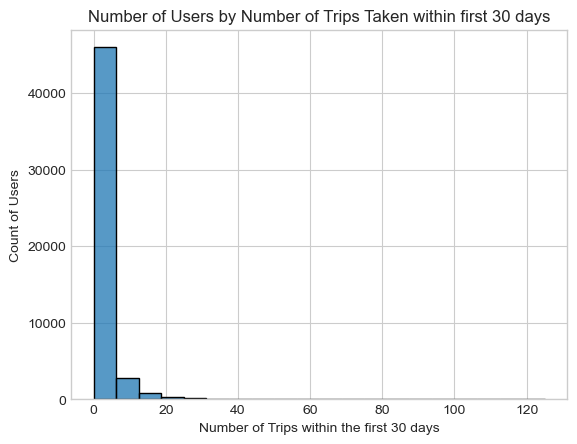

In [18]:
# Let's plot histograms of some of the numerical features
# We'll first start with how many trips users took within the first 30 days
sns.histplot(rider_df['trips_in_first_30_days'], bins = 20)
plt.xlabel('Number of Trips within the first 30 days')
plt.ylabel('Count of Users')
plt.title('Number of Users by Number of Trips Taken within first 30 days')
plt.show()

>The vast majority of users took between 0 and 5 trips in the first 30 days.  This is surprising to me, I would think the users would take more trips. The range of this is also quite high...there are some outliers here.

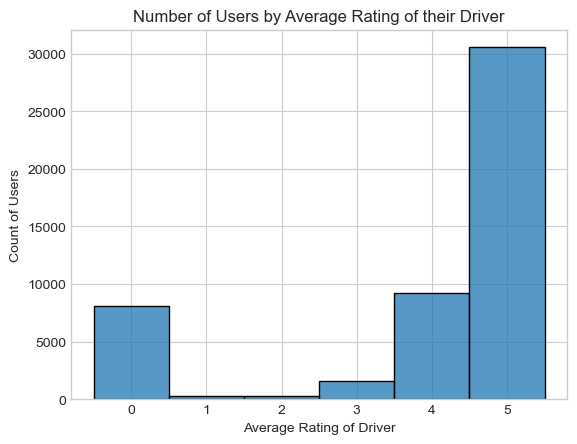

In [19]:
# Next let's look at count of users by average rating of driver
sns.histplot(rider_df['avg_rating_of_driver'], bins = 5, discrete = True)
plt.xlabel('Average Rating of Driver')
plt.ylabel('Count of Users')
plt.title('Number of Users by Average Rating of their Driver')
plt.show()

> Recall, that we changed null values to 0, therefore the 0 represented here means that they did not review their drivers. A vast majority of users had rated their drivers an average near 5.

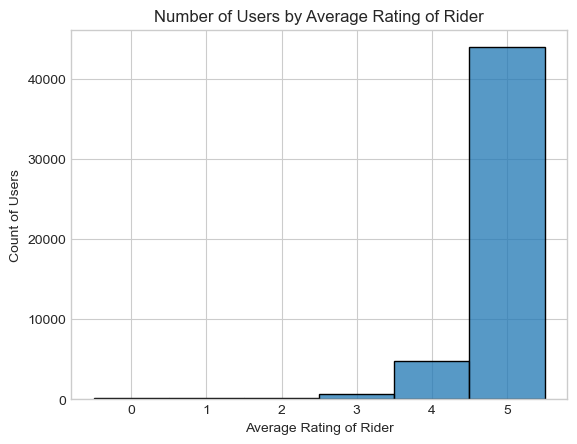

In [20]:
# Next let's look at count of users by average rating by driver
sns.histplot(rider_df['avg_rating_by_driver'], bins = 5, discrete = True)
plt.xlabel('Average Rating of Rider')
plt.ylabel('Count of Users')
plt.title('Number of Users by Average Rating of Rider')
plt.show()

>Drivers seem to be more consistent about giving ratings to their riders.  An overwhelming majority of riders have good ratings (4 or 5).

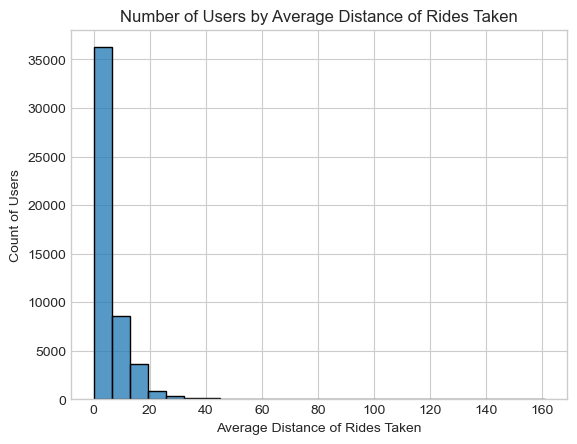

In [21]:
# Lastly, let's check out the average distance taken by riders
sns.histplot(rider_df['avg_dist'], bins = 25)
plt.xlabel('Average Distance of Rides Taken')
plt.ylabel('Count of Users')
plt.title('Number of Users by Average Distance of Rides Taken')
plt.show()

>Most rides are very short, with some major outliers

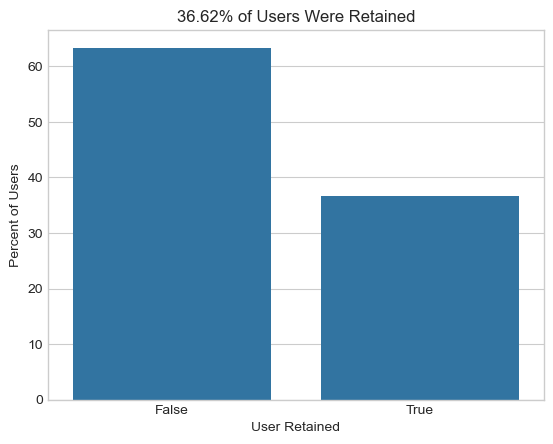

In [22]:
# Now let's look at the target variable and see how many users were retained
percent_retained = (len(rider_df[rider_df['retained'] == True]) / len(rider_df)) * 100

sns.countplot(data = rider_df, x = 'retained', stat='percent')
plt.xlabel('User Retained')
plt.ylabel('Percent of Users')
plt.title(f'{percent_retained:0.2f}% of Users Were Retained')
plt.show()

#### Predictive Modeling

In [23]:
# Remove the datetime columns from the dataset so we can run the model:
rider_df = rider_df.drop(columns = ['signup_date','last_trip_date'])

In [24]:
# Let's split the data into testing and training data
X = rider_df.drop(columns = 'retained')
y = rider_df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [25]:
# Let's build a random forest model to predict whether a user will be retained
rf = RandomForestClassifier(n_estimators= 300, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

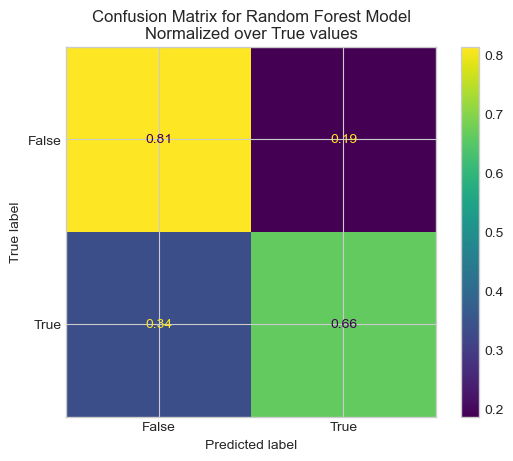

In [26]:
# Let's plot a confusion matrix to see how the model performed
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(cm, display_labels = rf.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest Model\nNormalized over True values')
plt.show()

>This model performed relatively well. In the test set, we accurately predicted 82% of the users that weren't retained and we accurately predicted 66% of the users that were retained.

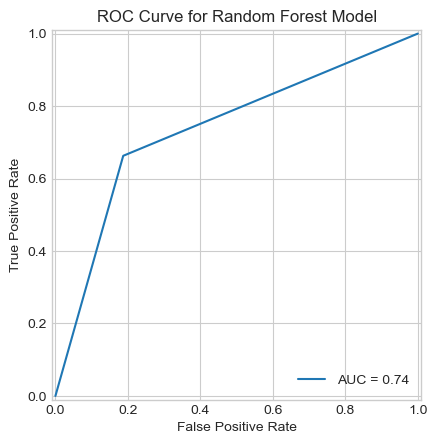

In [27]:
# Let's plot the ROC curve to look at AUC
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc=auc)
disp.plot()
plt.title('ROC Curve for Random Forest Model')
plt.show()

>An AUC of 0.74 for an initial model is pretty good. There is room for improvement with tweaking the model, but this shows that we are on the right track of building a decent predictive model.

In [28]:
# Let's gather the remaining evaluation metrics.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)

print(f'Accuracy:  {accuracy:0.2f}')
print(f'Precision: {precision:0.2f}')
print(f'Recall:    {recall:0.2f}')
print(f'F1 Score:  {f1:0.2f}')

Accuracy:  0.76
Precision: 0.67
Recall:    0.66
F1 Score:  0.67


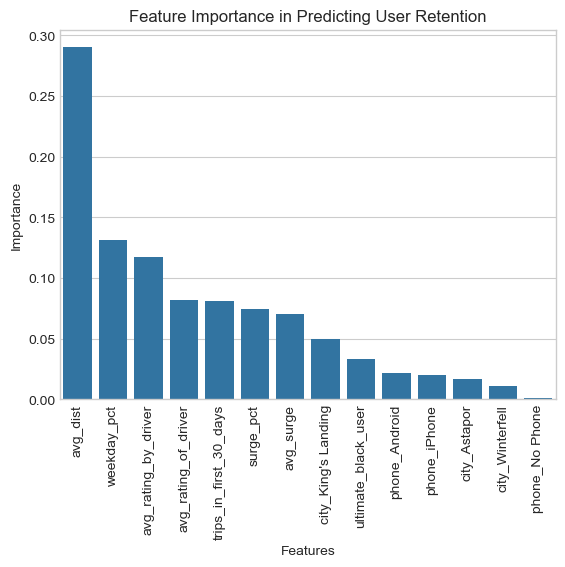

In [32]:
feature_importance_df = pd.DataFrame({'feature':rf.feature_names_in_,'importance':rf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False)
sns.barplot(data = feature_importance_df, x = 'feature', y = 'importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Predicting User Retention')
plt.xticks(rotation = 90)
plt.show()

#### Summary

I built a random forest model to predict whether users would be retained after 6 months.  The model had decent predictive power, but there is room for improvement. The model metrics were as follows:
* Accuracy:  0.76
* Precision: 0.67
* Recall:    0.66
* F1 Score:  0.67
* ROC AUC: 0.74

In order to improve upon the predictive model, I would suggest the following steps:
1. Explore the use of other models.  KNN and SVM models would be worth trying out and seeing if they have better predictive power.
2. Tune hyperparameters.  Within each model we can tune some parameters which may improve model outcomes.  For example in KNN we can vary the number of neighbors, or in this Random Forest model we can increase the number of estimators or vary the depth of the tree.
3. Gather additional data.  We can also work with the business to gather additional data which may be useful in predicting retention. For example, it could be that users traveling between cities are more likely to be retained.

From this analysis, it seems like the average distance users travel and whether or not a user travels during the week are good predictors of whether the users will be retained. Further analysis can be done on what exactly is a predictor of user retention (e.g., long vs. short travel distances, many vs. few weekday uses, etc). For now, the business can focus on increasing retention in the base which is not likely to be retained at the moment.  For example, if it turns out that users who tend to not travel during the week are unlikely to be retained, the company can send out targeted marketing to those customers to help promote retention among that group.